In [134]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import warnings
import numpy as np
from arch import arch_model
import statsmodels.graphics.tsaplots as sgt
from sklearn.model_selection import TimeSeriesSplit 
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings("ignore")
%matplotlib inline

# ЧАСТЬ 1

In [135]:
data = pd.read_csv('data/ghana_gdp.csv',parse_dates=["year"], index_col=["year"])
data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [136]:
data = data.rename(columns={'GDP (current US$)': 'gdp'})

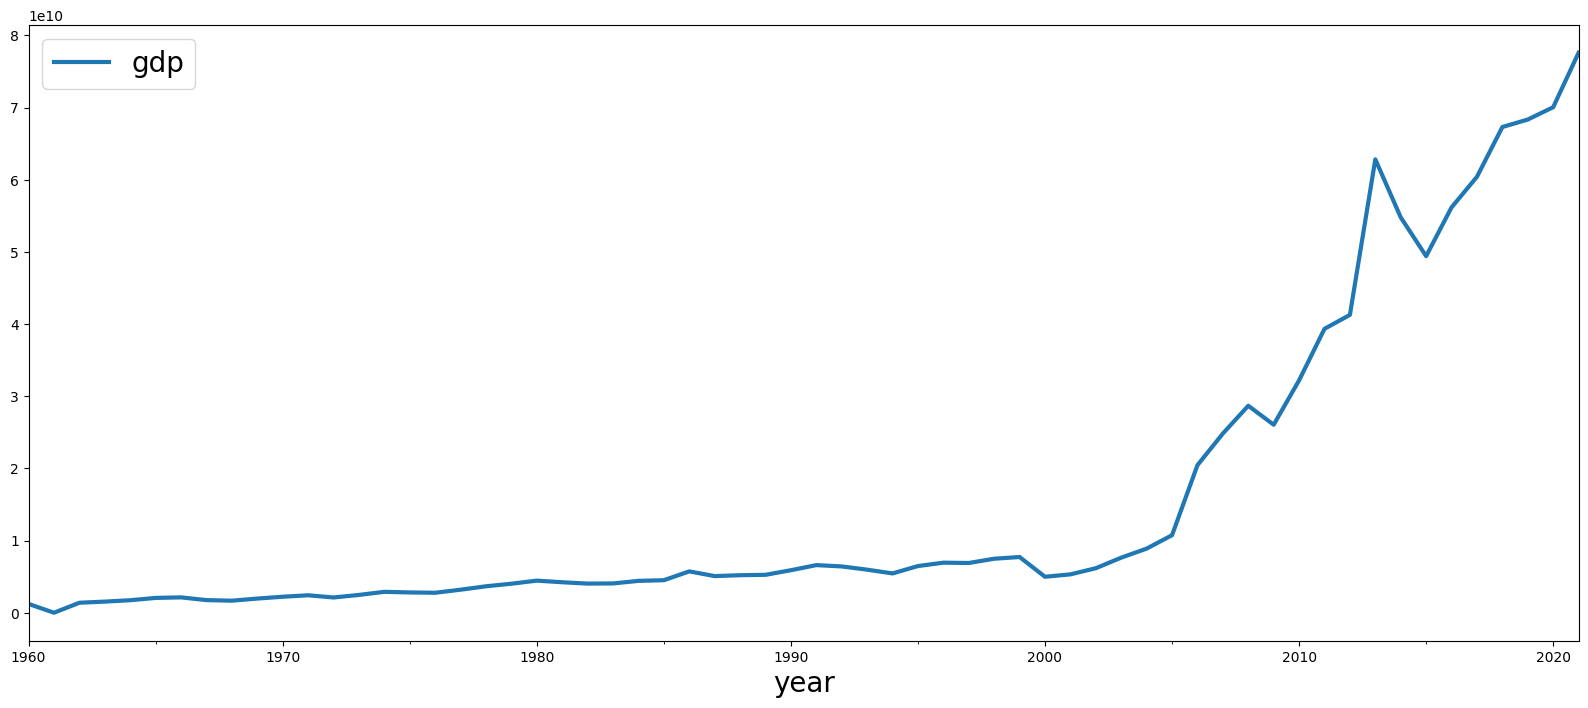

In [137]:
plt.rcParams["figure.figsize"] = 20, 8
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

data.plot()
plt.show()

Видим по графику, что примерно до 2000 года был слабый тренд на рост и отсутствие какой-либо сезонности и цикличности. После 2000 года тренд стал более выражен, рост сильнее , при этом был спад существенный в 2008 и еще более существенный в 2014-2016 годах. Но нельзя сказать о какой-либо цикличности и сезонности по данному графику после 2000 года. 

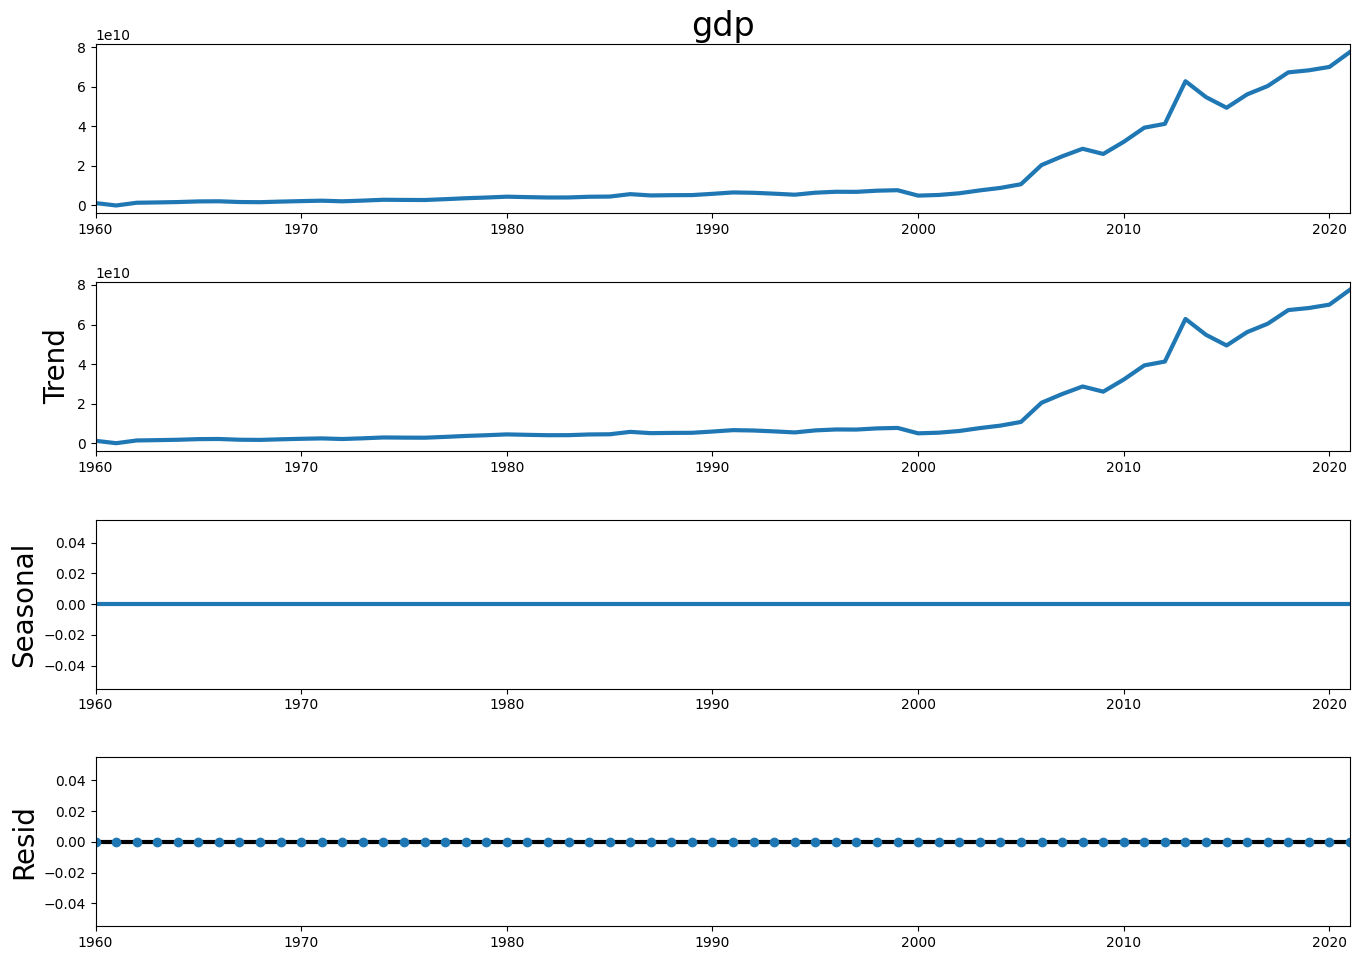

In [138]:
plt.rcParams["figure.figsize"] = 14, 10

result = seasonal_decompose(data.gdp)
result.plot()
plt.show()

Декомпозиция подтвердила предположения выше. 

In [139]:
data.tail(3)

,gdp
year,
2019-01-01,6.833754e+10
2020-01-01,7.004320e+10
2021-01-01,7.759428e+10


Видим, что последним наблюдением было 1 января 2021 года. Отложим последние три года как тестовую выборку (2019, 2020, 2021)

In [140]:
train_df = data.loc[:"2018-12-31"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

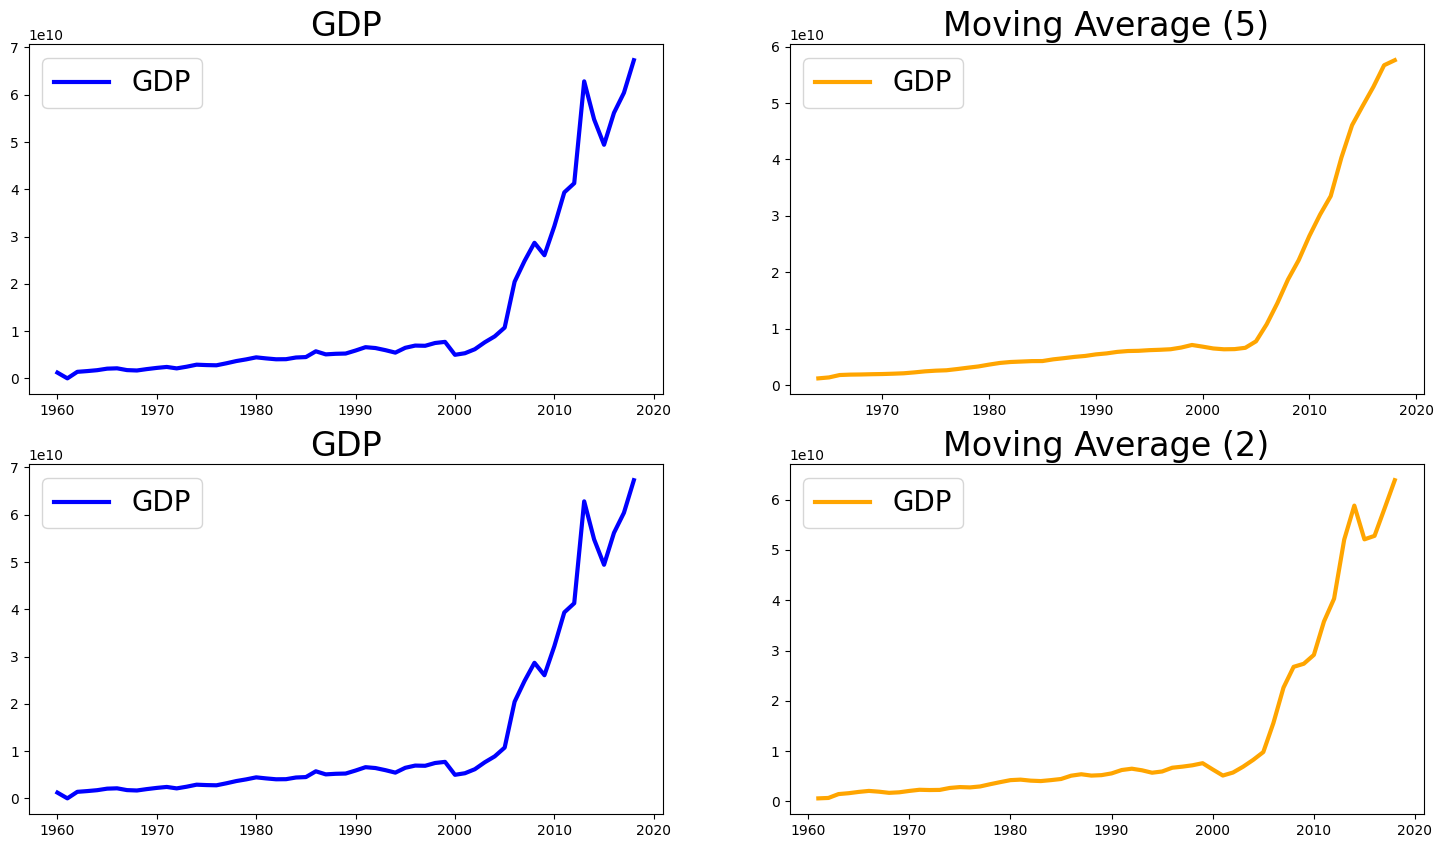

In [141]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

# Окно в месяц (Window = 5)
ax[0, 0].plot(train_df.gdp, color="blue", label="GDP")
ax[0, 0].set_title("GDP", size=24)
ax[0, 0].legend()

ax[0, 1].plot(
    train_df.gdp.rolling(window=5).mean(),
    color="orange",
    label="GDP",
)

ax[0, 1].set_title("Moving Average (5)", size=24)
ax[0, 1].legend()


# Окно в год (Window = 2)
ax[1, 0].plot(train_df.gdp, color="blue", label="GDP")
ax[1, 0].set_title("GDP", size=24)
ax[1, 0].legend()

ax[1, 1].plot(
    train_df.gdp.rolling(window=2).mean(),
    color="orange",
    label="GDP",
)

ax[1, 1].set_title("Moving Average (2)", size=24)
ax[1, 1].legend()

plt.show()

В графике с окном в 5 лет спад 14-16-ых годов сглажен, и мы видим плавно растущий до 2000 года, а затем сильно растущий после 2005 года тренд с небольшим плато в 2000-2005. В графике с окном в 2 года как спад прослеживается период 2000-2001, и 2014-2016 годы показывают яму, однако общий тренд все равно уверенно растет.

Проверим ряд на стационарность.

In [142]:
def stat_test(df):
    test = adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

stat_test(train_df)

adf:  0.6529066974885367
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
есть единичные корни, ряд не стационарен


Тест Дики-Фуллера показал, что ряд нестационарен. Дифференцируем его. 

In [143]:
diff_1 = train_df.diff(periods=1).dropna()
# проведем тест Дики-Фуллера снова
stat_test(diff_1)

adf:  -1.670248303832079
p-value:  0.4465029329713883
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
есть единичные корни, ряд не стационарен


In [144]:
# еще раз дифференцируем
diff_2 = diff_1.diff(periods=1).dropna()
# проведем тест Дики-Фуллера снова
stat_test(diff_2)

adf:  -2.640869056128483
p-value:  0.08484116917837797
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
есть единичные корни, ряд не стационарен


In [145]:
# еще раз дифференцируем
diff_3 = diff_2.diff(periods=1).dropna()
# проведем тест Дики-Фуллера снова
stat_test(diff_3)

adf:  -4.779623784828528
p-value:  5.9483276402250296e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
единичных корней нет, ряд стационарен


Получили интегрированный ряд третьего порядка, значит параметр d = 3. Построим коррелограммы ACF и PACF и выберем параметры p и q.

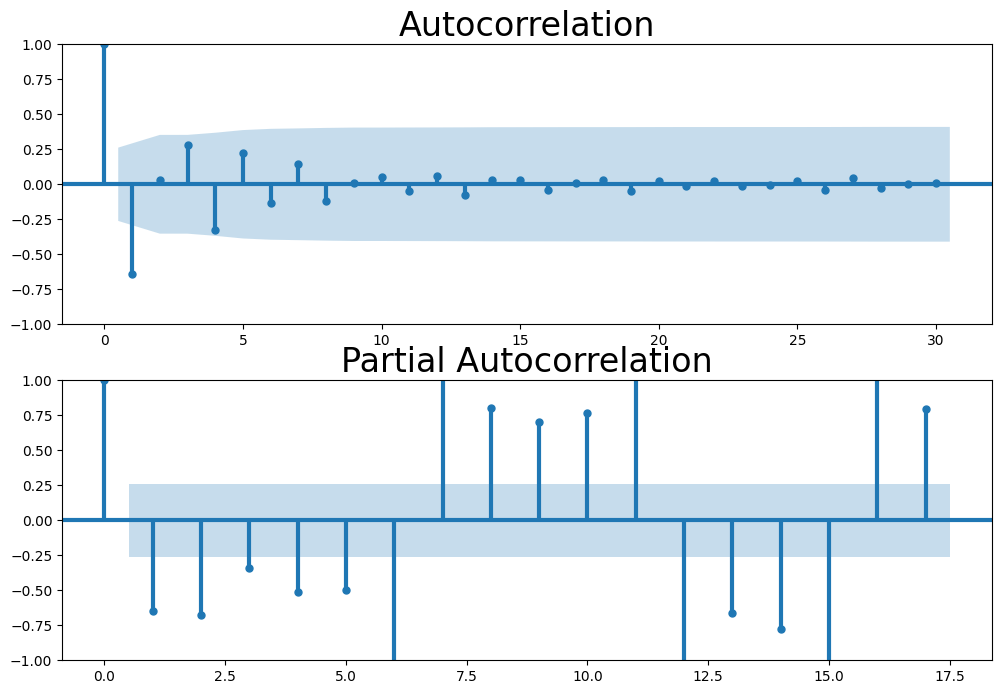

In [146]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_3.values.squeeze(), lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_3, lags=17, ax=ax2)

По графику автокорреляции берем q = 5, так как после шестого лага значения начинают колебаться около нуля. Значение p возьмем равным 7, так как в этой точке частичная корреляция максимальная, а дальше следует уменьшение и снова повторение с циклом в 5 шагов примерно. 

Начнем построение модели ARIMA со следующими параметрами:
- p = 7
- d = 3 
- q = 5

In [147]:
arima_model = ARIMA(train_df["gdp"].dropna(), order=(7, 3, 5))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gdp   No. Observations:                   59
Model:                 ARIMA(7, 3, 5)   Log Likelihood               -1302.059
Date:                Thu, 26 Oct 2023   AIC                           2630.118
Time:                        19:32:08   BIC                           2656.448
Sample:                    01-01-1960   HQIC                          2640.326
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2028      4.348     -0.277      0.782      -9.724       7.319
ar.L2         -1.4772      6.755     -0.219      0.827     -14.716      11.762
ar.L3         -1.3818      8.259     -0.167      0.867     -17.569      14.806
ar.L4         -1.2118      8.655     -0.140      0.889     -18.175      15.751
ar.L5         -0.7564      8.491     -0.089      0.929     -17.398      15.885
ar.L6         -0.4386      6.758     -0.065      0.948     -13.684      12.807
ar.L7          0.2484      4.054      0.061      0.951      -7.697       8.194
ma.L1         -0.6753      4.359     -0.155      0.877      -9.219       7.868
ma.L2         -0.0949      1.620     -0.059      0.953      -3.270       3.080
ma.L3          0.2115      1.724      0.123      0.902      -3.167       3.590
ma.L4         -0.7750      1.526     -0.508      0.612      -3.766       2.216
ma.L5          0.3661      2.833      0.129      0.897      -5.186       5.918
sigma2      9.849e+18   5.83e-18   1.69e+36      0.000    9.85e+18    9.85e+18
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                34.21
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):              53.77   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.7e+53. Standard errors may be unstable.
"""

Получили AIC = 2630. Теперь подберем параметры с помощью пакета pmdarima. Методом перебора было выявлено, что лучше использовать модель ся большим  m, возьмем m, равное 50.

smodel = pm.auto_arima(
    train_df,
    start_p=6,
    d=3,
    start_q=5,
    max_p=25,
    max_q=10,
    D=1,
    start_P=1,
    m=50,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Параметр AIC, найденный с pmdarima,  оказался существенно ниже. Построим модель и предсказания модели на тестовой выборке с заданными параметрами: создадим файл предсказаний и сделаем предсказание.

In [148]:
best_model = ARIMA(train_df["gdp"].dropna(), order=(0, 3, 2), seasonal_order=(0, 1, 0, 50))
best_model_fit = best_model.fit()
best_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                               gdp   No. Observations:                   59
Model:             ARIMA(0, 3, 2)x(0, 1, [], 50)   Log Likelihood                -149.519
Date:                           Thu, 26 Oct 2023   AIC                            305.038
Time:                                   19:32:09   BIC                            304.413
Sample:                               01-01-1960   HQIC                           302.537
                                    - 01-01-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9295      3.651     -0.528      0.597      -9.086       5.227
ma.L2          0.9431      4.191      0.225      0.822      -7.270       9.156
sigma2      5.887e+20      9e-22   6.54e+41      0.000    5.89e+20    5.89e+20
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):                 0.30
Prob(Q):                              0.51   Prob(JB):                         0.86
Heteroskedasticity (H):               0.01   Skew:                             0.44
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.38e+59. Standard errors may be unstable.
"""

Модель показала AC = 305.

In [149]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = best_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["gdp"] = data["gdp"]

forecast = best_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower gdp"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper gdp"]

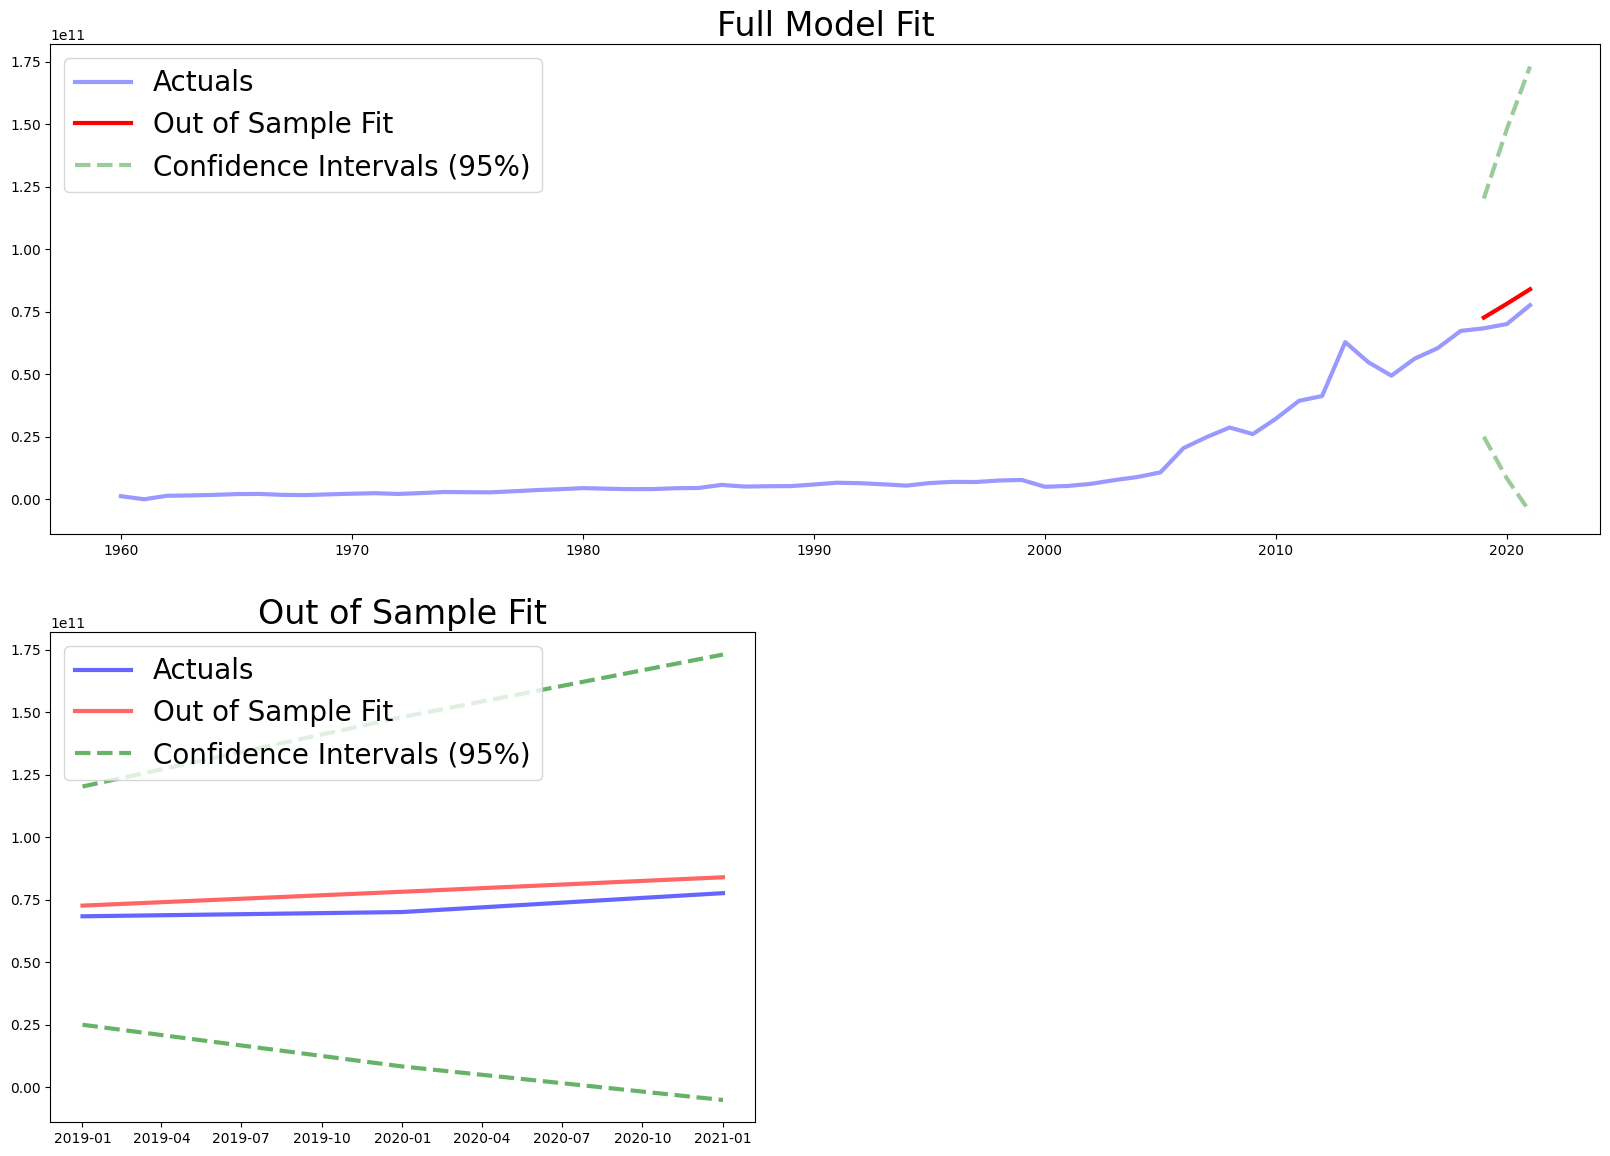

In [150]:
plt.rcParams["figure.figsize"] = 20, 14

plt.subplot(2, 1, 1)
plt.plot(pred_df["gdp"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["gdp"], color="blue", label="Actuals", alpha=0.6
)
plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

Наша модель уловила тренд, кроме тренда модель больше не показала никаких особенностей.

# ЧАСТЬ 2

Проверим данные на наличие пропущенных дат.

In [151]:
# Применяем метод asfreq с частотой 'AS' (годовая частота)
df_asfreq = data.asfreq(freq='AS')

# Проверяем наличие пропущенных дат
missing_dates = df_asfreq[df_asfreq.isnull().any(axis=1)].sum()
print(missing_dates)

gdp    0.0
dtype: float64


Пропущенных значений нет

In [152]:
# проверим на наличие нулей
data[data['gdp']==0]

,gdp
year,
1961-01-01,0.0


In [153]:
# заменим строку с нулевым значением
data['gdp'] = data['gdp'].apply(lambda x: np.nan if x==0 else x)

In [154]:
# выполним интерполяцию с использованием метода .interpolate()
int_data = data['gdp'].interpolate(method='linear')
data = pd.DataFrame(int_data, columns=["gdp"])

In [155]:
# проверим на наличие нулей
data[data['gdp']==0]

,gdp
year,


Нулей больше нет

In [156]:
# снова разделим выборку 
train_df = data.loc[:"2018-12-31"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

In [157]:
# Проверим ряд на стационарность
stat_test(train_df)

adf:  0.8030073326980115
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
есть единичные корни, ряд не стационарен


Тест Дики-Фуллера показал, что ряд нестационарен. Дифференцируем его. 

In [158]:
diff_1 = train_df.diff(periods=1).dropna()
# проведем тест Дики-Фуллера снова
stat_test(diff_1)

adf:  -1.8255652246436056
p-value:  0.3678451527656314
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
есть единичные корни, ряд не стационарен


Ряд по-прежнему не стационарен, снова дифференцируем.

In [159]:
diff_2 = diff_1.diff(periods=1).dropna()
# проведем тест Дики-Фуллера снова
stat_test(diff_2)

adf:  -2.634634746007848
p-value:  0.08604813722197563
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
есть единичные корни, ряд не стационарен


Ряд по-прежнему не стационарен, снова дифференцируем.

In [160]:
diff_3 = diff_2.diff(periods=1).dropna()
# проведем тест Дики-Фуллера снова
stat_test(diff_3)

adf:  -4.825603687304028
p-value:  4.8573180767997966e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
единичных корней нет, ряд стационарен


Ряд стационарен. Двигаемся дальше.
Мы получили интегрированный ряд третьего порядка, значит параметр d = 3. Построим коррелограммы ACF и PACF и выберем параметры p и q.

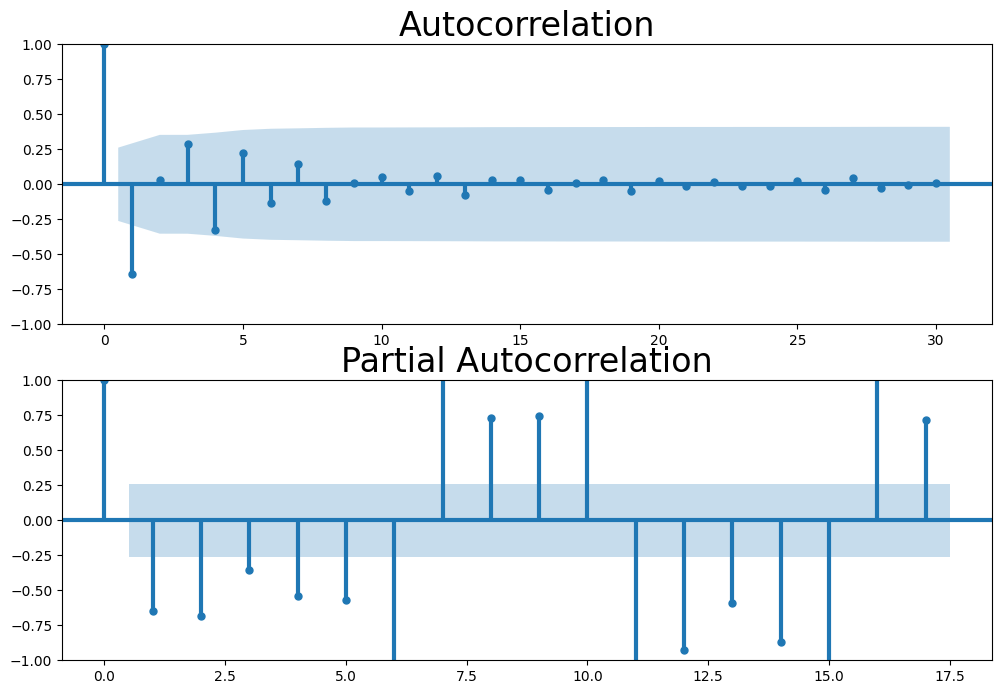

In [161]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_3.values.squeeze(), lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_3, lags=17, ax=ax2)

По графику автокорреляции берем q = 5, так как дальше значения начинают колебаться около нуля. Значение p возьмем равным 7, так как в этой точке частичная корреляция максимальная, а дальше следует уменьшение и снова повторение с циклом в 5 шагов примерно. 
Начнем построение модели ARIMA со следующими параметрами:
- p = 7
- d = 3 
- q = 5

In [162]:
new_arima_model = ARIMA(train_df["gdp"].dropna(), order=(7, 3, 5))
new_arima_model_fit = new_arima_model.fit()
new_arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gdp   No. Observations:                   59
Model:                 ARIMA(7, 3, 5)   Log Likelihood               -1301.963
Date:                Thu, 26 Oct 2023   AIC                           2629.927
Time:                        19:32:10   BIC                           2656.256
Sample:                    01-01-1960   HQIC                          2640.135
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1958      4.693     -0.255      0.799     -10.395       8.003
ar.L2         -1.4972      7.300     -0.205      0.837     -15.805      12.811
ar.L3         -1.3784      9.017     -0.153      0.878     -19.051      16.294
ar.L4         -1.1870      9.438     -0.126      0.900     -19.686      17.312
ar.L5         -0.7202      9.209     -0.078      0.938     -18.770      17.330
ar.L6         -0.4424      7.241     -0.061      0.951     -14.635      13.750
ar.L7          0.2542      4.507      0.056      0.955      -8.579       9.087
ma.L1         -0.6436      4.626     -0.139      0.889      -9.710       8.423
ma.L2         -0.0972      1.585     -0.061      0.951      -3.205       3.010
ma.L3          0.1706      1.785      0.096      0.924      -3.329       3.670
ma.L4         -0.7757      1.450     -0.535      0.593      -3.617       2.065
ma.L5          0.3841      3.041      0.126      0.899      -5.576       6.345
sigma2      1.031e+19   7.63e-18   1.35e+36      0.000    1.03e+19    1.03e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                37.27
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):             106.81   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.22e+53. Standard errors may be unstable.
"""

Получили совсем небольшое снижение параметра AIC с 2630 до 2629 по сравнению с первоначальной моделью arima_model.

Теперь подберем параметры с помощью пакета pmdarima. Методом перебора было выявлено, что лучше использовать модель с большим  m.
 Возьмем m, равное 50.

new_smodel = pm.auto_arima(
    train_df,
    start_p=6,
    d=3,
    start_q=5,
    max_p=25,
    max_q=10,
    D=1,
    start_P=1,
    m=50,
    test="adf",
    error_action="ignore",
    trace=True,
)

new_smodel.summary()

mdarima показала лучший набор параметров: ARIMA(0,3,2)(0,1,0,50), используем его. 

In [163]:
# строим модель на новых данных 
new_best_model = ARIMA(train_df["gdp"].dropna(), order=(0, 3, 2), seasonal_order=(0, 1, 0, 50))
new_best_model_fit = new_best_model.fit()
new_best_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                               gdp   No. Observations:                   59
Model:             ARIMA(0, 3, 2)x(0, 1, [], 50)   Log Likelihood                -149.340
Date:                           Thu, 26 Oct 2023   AIC                            304.681
Time:                                   19:32:10   BIC                            304.056
Sample:                               01-01-1960   HQIC                           302.180
                                    - 01-01-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9311      3.408     -0.567      0.571      -8.610       4.748
ma.L2          0.9448      3.926      0.241      0.810      -6.750       8.640
sigma2      5.475e+20   1.09e-21   5.04e+41      0.000    5.47e+20    5.47e+20
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):                 0.30
Prob(Q):                              0.51   Prob(JB):                         0.86
Heteroskedasticity (H):               0.01   Skew:                             0.44
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.66e+60. Standard errors may be unstable.
"""

In [164]:
# сделаем предсказание
pred_df = pd.DataFrame(index=data.index)
pred_df["model_preds"] = best_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1])

pred_df["gdp"] = data["gdp"]
forecast = best_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%
pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower gdp"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper gdp"]

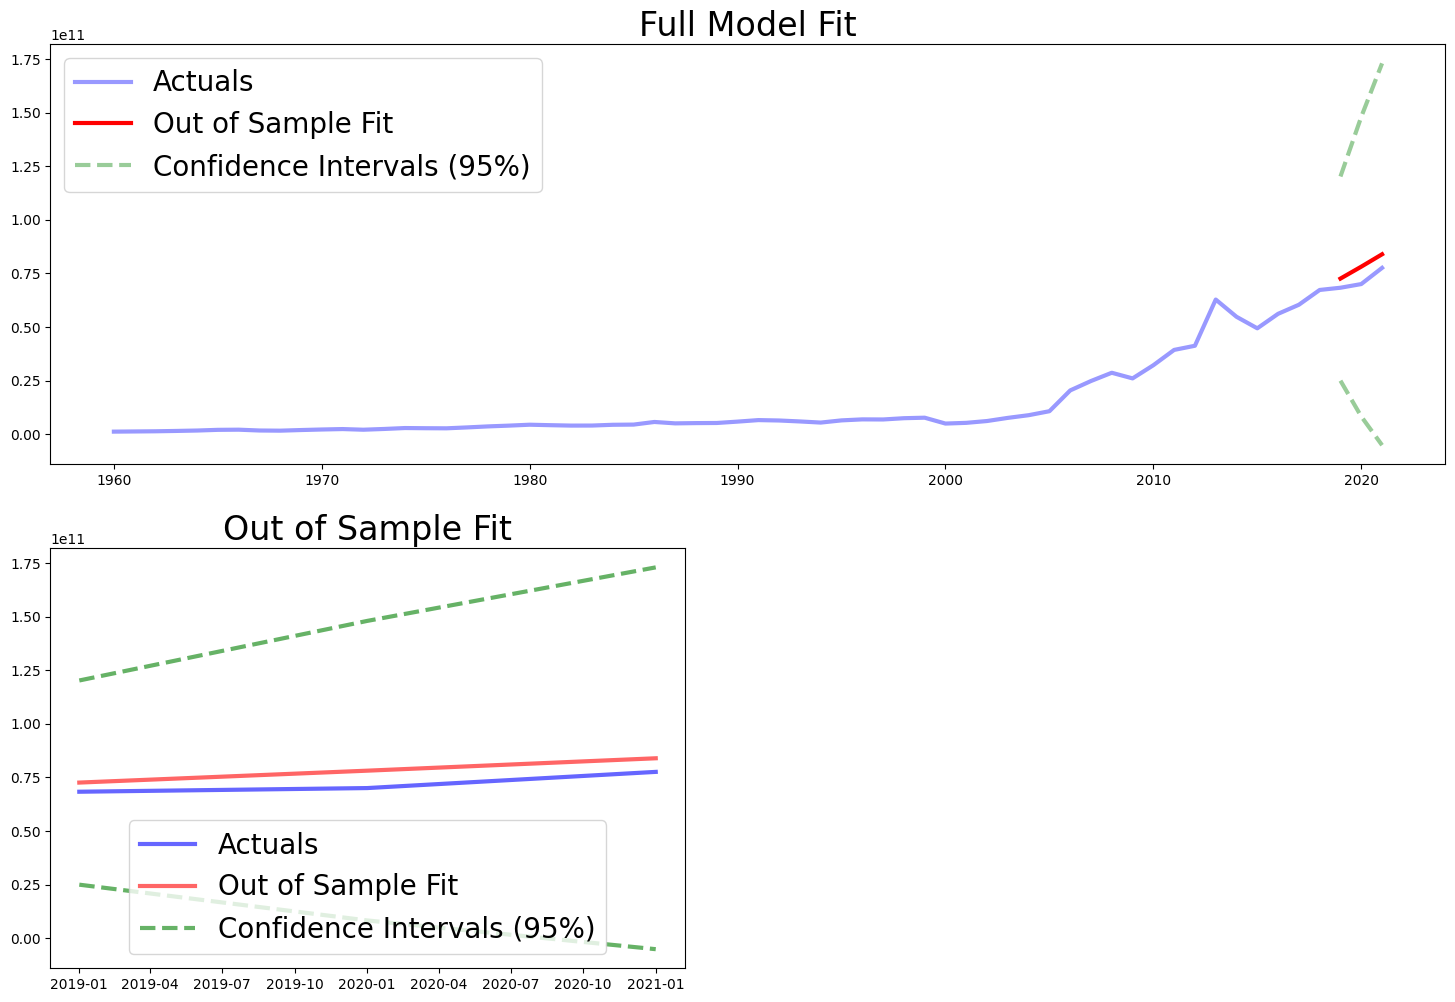

In [165]:
# визуализируем
plt.rcParams["figure.figsize"] = 18, 12
plt.subplot(2, 1, 1)
plt.plot(pred_df["gdp"], color="blue", label="Actuals", alpha=0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds"],color="red",linestyle="-",label="Out of Sample Fit")
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"],color="green",linestyle="--",label="Confidence Intervals (95%)",alpha=0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color="green", linestyle="--", alpha=0.4)
plt.title("Full Model Fit", size=24)
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(pred_df.loc[test_df.index]["gdp"], color="blue", label="Actuals", alpha=0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds"],color="red",linestyle="-",label="Out of Sample Fit",alpha=0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"],color="green",linestyle="--",label="Confidence Intervals (95%)",alpha=0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"],color="green",linestyle="--",alpha=0.6)
plt.title("Out of Sample Fit", size=24)
plt.legend()
plt.show()

До интерполяции AIC был 305, сейчас 304. Небольшое улучшение присутствует, то есть модель чуть лучше уловила характер данных. Но у нас был всего один пропуск, поэтому, вероятно, значительных изменений и не должно было произойти. В предсказании так же видим тренд и все.

# ЧАСТЬ 3

In [166]:
tscv = TimeSeriesSplit(n_splits=3, test_size=7)
train_test_groups = tscv.split(data.gdp) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 41 TEST size: 7
TRAIN size: 48 TEST size: 7
TRAIN size: 55 TEST size: 7


In [167]:
data["gdp_vol"] = data.gdp.pct_change(1).mul(100).abs()
data["gdp_vol"].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Name: gdp_vol, dtype: float64

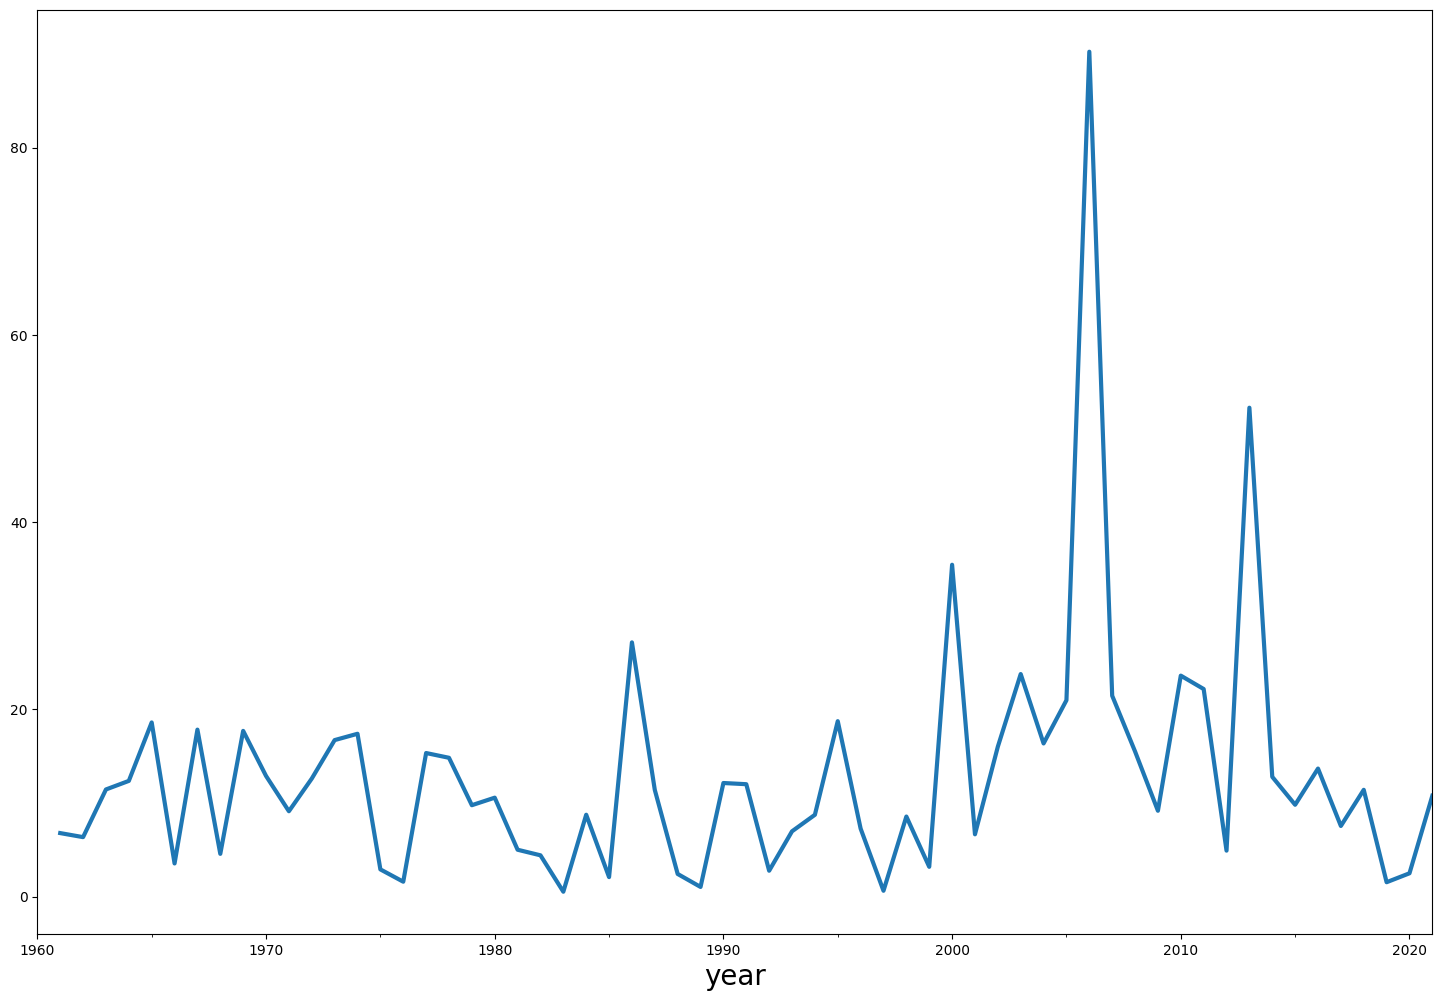

In [168]:
data["gdp_vol"].plot()
plt.show()

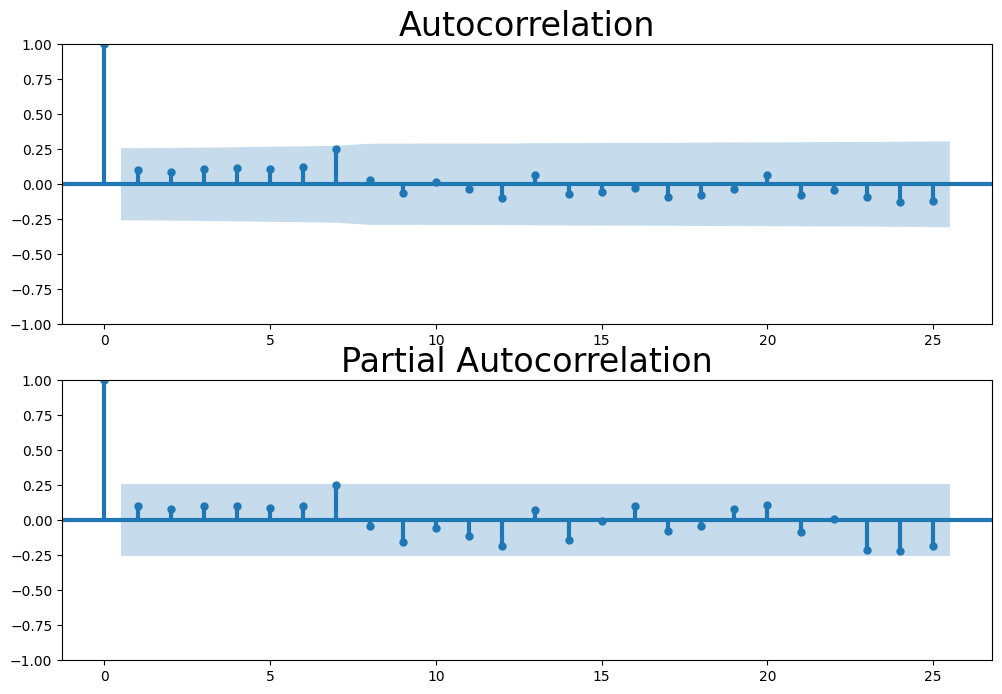

In [169]:
train_df = data.loc[:"2018-12-31"]
test_df = data.loc["2019-01-01":]

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df.gdp_vol[1:].values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df.gdp_vol[1:], lags=25, ax=ax2)


In [170]:
stat_test(train_df.gdp_vol[1:])

adf:  -6.725311059553779
p-value:  3.4014596148856493e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
единичных корней нет, ряд стационарен


Глядя на график PACF , становится ясно, что самый значтельный - 7 лаг, а затем уровни значимости значительно падают. Итак, мы построим модель GARCH(7, 7).

In [171]:
garch_df = pd.DataFrame(data["gdp_vol"].loc[data.index])
garch_df.loc[train_df.index, "gdp_vol"] = train_df["gdp_vol"].dropna()
model = arch_model(garch_df["gdp_vol"].dropna(), p=7, q=7)
# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки
model_results = model.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:     91,   Neg. LLF: 234.38048115955718
Iteration:     10,   Func. Count:    179,   Neg. LLF: 214.61759052175603
Iteration:     15,   Func. Count:    265,   Neg. LLF: 214.40871495512866
Iteration:     20,   Func. Count:    350,   Neg. LLF: 214.10079395318482
Iteration:     25,   Func. Count:    435,   Neg. LLF: 214.01143994526097
Optimization terminated successfully    (Exit mode 0)
            Current function value: 214.00780231871062
            Iterations: 29
            Function evaluations: 492
            Gradient evaluations: 28


In [172]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                gdp_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -214.008
Distribution:                  Normal   AIC:                           460.016
Method:            Maximum Likelihood   BIC:                           492.983
                                        No. Observations:                   58
Date:                Thu, Oct 26 2023   Df Residuals:                       57
Time:                        19:32:11   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.8666      1.572      7.550  4.349e-14 [  8.786, 14.947]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         44.1055     42.301      1.043      0.297    [-38.802,1.270e+02]
alpha[1]   3.2351e-08  7.767e-02  4.165e-07      1.000      [ -0.152,  0.152]
alpha[2]   7.8463e-08  2.299e-02  3.412e-06      1.000 [-4.507e-02,4.507e-02]
alpha[3]   6.5621e-14  6.853e-02  9.576e-13      1.000      [ -0.134,  0.134]
alpha[4]   3.6162e-03  1.492e-02      0.242      0.809 [-2.563e-02,3.286e-02]
alpha[5]   6.2496e-14  1.274e-02  4.906e-12      1.000 [-2.497e-02,2.497e-02]
alpha[6]       0.7319      0.915      0.800      0.424      [ -1.062,  2.525]
alpha[7]       0.1024      0.643      0.159      0.873      [ -1.157,  1.362]
beta[1]    5.7084e-07      0.501  1.139e-06      1.000      [ -0.982,  0.982]
beta[2]    3.6496e-07  6.190e-02  5.896e-06      1.000      [ -0.121,  0.121]
beta[3]    3.4349e-07  2.869e-02  1.197e-05      1.000 [-5.624e-02,5.624e-02]
beta[4]    3.0295e-07  9.122e-02  3.321e-06      1.000      [ -0.179,  0.179]
beta[5]    1.7888e-05  5.268e-02  3.396e-04      1.000      [ -0.103,  0.103]
beta[6]    3.6179e-07  3.014e-02  1.200e-05      1.000 [-5.908e-02,5.908e-02]
beta[7]    2.9083e-07      1.155  2.517e-07      1.000      [ -2.265,  2.265]
=============================================================================

Covariance estimator: robust
"""

In [178]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[test_df.index]

year
2019-01-01     1.542746
2020-01-01     2.495937
2021-01-01    10.780603
Name: gdp_vol, dtype: float64

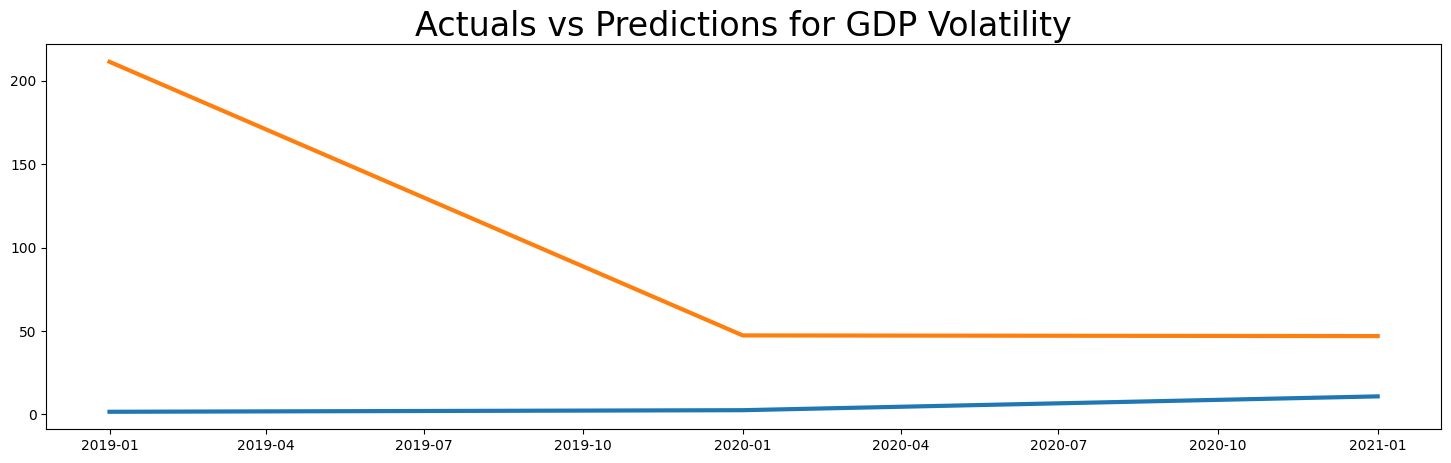

In [180]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["gdp_vol"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for GDP Volatility", size=24)

plt.show()

In [175]:
from sklearn.metrics import mean_squared_error

mean_squared_error(
    predictions_df["gdp_vol"].abs(), predictions_df["Predictions"]
)

15799.81566534356

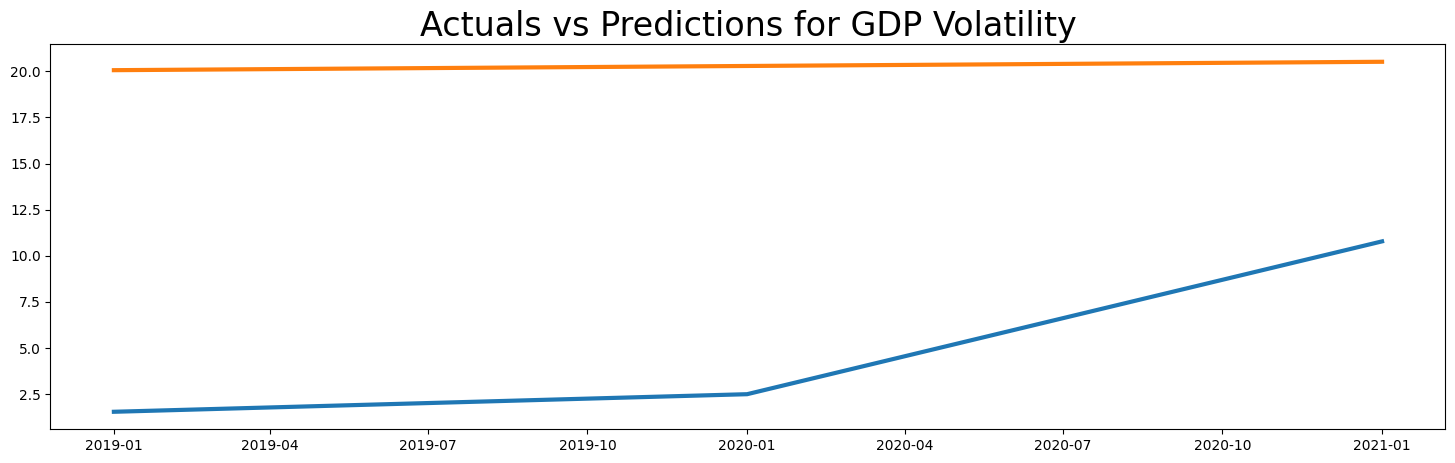

In [177]:
from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(data["gdp_vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(data["gdp_vol"].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["gdp_vol"].fillna(0)
y_test = test_df["gdp_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.title("Actuals vs Predictions for GDP Volatility", size=24)
plt.show()


В GARCH модели разброс оказался следующим: линия предсказания начала с отметки 200 в 2019 году и далее спустилась к значениям 50 для последующих двух предсказаний в то время, как актуальные значения были на уровне 2,5 , 10 и 10. Линейная регрессия оказалась ближе к актуальным данным по расстоянию, но никакой дисперсии мы тут не наблюдаем.
 Судя по полученному графику, модель не уловила дисперсию, так как такое поведение было для неё новым и подобные случаи отсутствовали в обучающей выборке.